# EE046853: CNN Optimization with PyTorch


## Part I. PyTorch Introduction

*For readability, this walkthrough will not detail each an every function argument; you are highly encouraged to check the PyTorch documentation by yourselves, and if something is still not clear, ask in the Moodle forum.*

### Loading CIFAR-10
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
We'll walkthrough how to code a CNN for image classification with PyTorch for the CIFAR-10 dataset. At the end, you'll do the same thing with CIFAR-100. More details can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

<center><img src="https://raw.githubusercontent.com/gilshm/ee046853/master/imgs/01_cifar10_dataset.png" alt="CIFAR-10 dataset" width="600"/></center>

PyTorch is capable of downloading CIFAR-10 (and 100) automatically. Notice that batch size is set to 128, i.e., each feed-forward consists of 128 images.
Regarding the *transforms.Normalize((...), (...))*, this is input data preprocessing (normalization) - for further details, see [here](http://cs231n.github.io/neural-networks-2/#datapre).

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ("apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
           "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
           "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "cra", "crocodile", "cup",
           "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house",
           "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man",
           "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid",
           "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine",
           "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew",
           "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper",
           "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle",
           "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm")

#TODO: change to new classes form CIFAR-100
# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Let's visualize some input images from the training set. Notice how the train loader will load different batches each time, since we initialized it with *shuffle=True*.

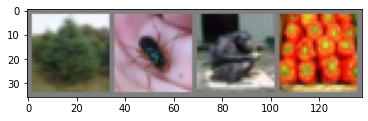

pine_tree beetle chimpanzee sweet_pepper


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get a batch from the train loader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:4, :, :, :]))

# Print their labels
print(' '.join('%s' % classes[labels[j]] for j in range(4)))


### The CNN Model
Below an example of a simple "light" AlexNet network, that is, 2 CONV layers followed by 3 FC layers. ReLU and max pooling are used as well.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# ID's
ID1 = [2, 0, 8, 1, 5, 7, 8, 2, 6]
ID2 = [2, 1, 1, 6, 1, 0, 7, 0, 4]

ID1Max = max(ID1) #8
ID2Max = max(ID2) #7
ID2Min = min(ID2) #0

Conv1kernelSize = ID1Max
Conv2kernelSize = 9-ID2Min

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=Conv1kernelSize)
        print('-I- conv1 IC:{} OC:{} Kernel:{}x{}'.format(3, 6, Conv1kernelSize, Conv1kernelSize))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        print('-I- pool Kernel:{}x{}, stride:{}'.format(2, 2, 2))
        self.conv2 = nn.Conv2d(6, 16, Conv2kernelSize)
        print('-I- conv2 IC:{}, OC:{}, Kernel:{}x{}'.format(6, 16, Conv2kernelSize, Conv2kernelSize))
        self.fc1 = nn.Linear(in_features=16*2*2, out_features=120)
        print('-I- fc1 IC:{}, OC:{}'.format(16*2*2, 120))
        self.fc2 = nn.Linear(120, 84)
        print('-I- fc2 IC:{}, OC:{}'.format(120, 84))
        self.fc3 = nn.Linear(84, 100) # *Now we have 100 classes to clasify
        print('-I- fc3 IC:{}, OC:{}'.format(84, 100))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print('-I- fc1 input features: {}'.format(x.shape))
        x = x.view(-1, 16*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

-I- conv1 IC:3 OC:6 Kernel:8x8
-I- pool Kernel:2x2, stride:2
-I- conv2 IC:6, OC:16, Kernel:9x9
-I- fc1 IC:64, OC:120
-I- fc2 IC:120, OC:84
-I- fc3 IC:84, OC:100


### Training
To train a neural network, we need to choose an optimizer and define a loss function.
As an optimizer, we choose the stochastic gradient descent (SGD) with a learning rate (LR) of 0.01.
For the loss function, we choose the cross-entropy loss.


In [5]:
import torch.optim as optim


LR = 0.01

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=LR)


We define a training function and a validation function.

For each batch, the training function feedforwards the inputs from the training set through the network (*model(images)*), computes the loss versus the reference or ground truth (*criterion(output, target)*), backward propogates the gradients from the loss function (*loss.backward()*), and updates the parameters (*optimizer.step()*).

The validation function uses the validation set, which the network did not explicitly trained on, to check the model accuracy.

In [6]:
import time


def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            progress.display(i)
            
            
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 100 == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

Below are additional auxiliary functions (e.g., gathering statistics).



In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
      
      
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
      
      
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

It's training time! we'll try 10 epochs.

In [8]:
# ID's
ID1 = [2, 0, 8, 1, 5, 7, 8, 2, 6]
ID2 = [2, 1, 1, 6, 1, 0, 7, 0, 4]

ID1ID2Mult = [ID1[i]*ID2[i] for i in range(len(ID1))]
NumOfEpochs = max([max(ID1ID2Mult), 30])
print(NumOfEpochs)

EPOCHS = NumOfEpochs

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(0, EPOCHS):
    # train for one epoch
    train(trainloader, net, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(testloader, net, criterion)

    scheduler.step()

56
Epoch: [0][  0/391]	Time  7.178 ( 7.178)	Data  0.127 ( 0.127)	Loss 4.6105e+00 (4.6105e+00)	Acc@1   0.00 (  0.00)	Acc@5   3.12 (  3.12)
Epoch: [0][100/391]	Time  0.008 ( 0.107)	Data  0.001 ( 0.030)	Loss 4.6012e+00 (4.6075e+00)	Acc@1   0.78 (  0.91)	Acc@5   3.91 (  4.74)
Epoch: [0][200/391]	Time  0.009 ( 0.068)	Data  0.001 ( 0.026)	Loss 4.6100e+00 (4.6073e+00)	Acc@1   1.56 (  0.99)	Acc@5   3.91 (  4.96)
Epoch: [0][300/391]	Time  0.028 ( 0.054)	Data  0.024 ( 0.024)	Loss 4.6057e+00 (4.6070e+00)	Acc@1   1.56 (  0.99)	Acc@5   5.47 (  5.03)
Test: [ 0/79]	Time  0.143 ( 0.143)	Loss 4.6053e+00 (4.6053e+00)	Acc@1   0.78 (  0.78)	Acc@5   6.25 (  6.25)
 * Acc@1 0.990 Acc@5 5.110
Epoch: [1][  0/391]	Time  0.161 ( 0.161)	Data  0.147 ( 0.147)	Loss 4.6000e+00 (4.6000e+00)	Acc@1   0.00 (  0.00)	Acc@5   7.03 (  7.03)
Epoch: [1][100/391]	Time  0.052 ( 0.028)	Data  0.047 ( 0.022)	Loss 4.6089e+00 (4.6065e+00)	Acc@1   0.00 (  0.96)	Acc@5   4.69 (  5.03)
Epoch: [1][200/391]	Time  0.036 ( 0.028)	Data  0.031

## Part II. Quantization
For simplicity's sake, we will only tackle weight quantization.
There are many quantization methods, we will a simple quantization method which works quite well, at least with 8-bit quantization.
It is a post-training quantization method, that is, not further training is conducted after quantization.

The quantization is symmetric and uniform, thereby it may be easily implemented in hardware. For $B$ bits quantization, the quantization range is $\left[ -2^{B-1}, 2^{B-1}-1 \right]$. For example, for 8-bit quantization, the range is $[-2^7, 2^7 - 1] = [-128, 127]$.

<center><img src="https://raw.githubusercontent.com/gilshm/ee046853/master/imgs/quant_sym.png" alt="Resnet example" width="300"/></center>
<center><small>(Figure from <a href="https://nervanasystems.github.io/distiller/algo_quantization.html">here</a>.)</small></center>

What symmetric uniform quantization does is normalizing the weight range (symmetrically) and then puts each weight into the appropriate bins which are uniform in size. That is, assume a weight tensor $W$, and without loss in generality, assume $W_{min} < W_{max}$. The scale factor is, therefore, $\Delta=\frac{2 \cdot W_{max}}{2^B - 1}$. Now, for each weight $w_i$ in $W$, the quantized weight is equal to $w^{(q)}_i = \text{round}\left(  \frac{w}{\Delta}  \right)$. The "full precision quantized" weight is equal to $w^{(q)}_i \Delta$.

What makes it easy to implement in hardware? Well, the nice thing is that the entire layer can be performed based on INT hardware, and only at the end we need to multiply the *result* with the FP scaling factor.


### The Quantization Function

Before diving into the quantization function, we will first create functions to save and load the model weights, so after quantization we'll be able to load the original weights.

In [10]:
def save_weights(net):
  for m in net.modules():
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
      m.weight_bak = m.weight.data.clone()


def load_weights(net):
  for m in net.modules():
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
      m.weight.data = m.weight_bak.clone()

Now, the quantization function.

In [11]:
Q_BITS = 16
DELTA_PER_CHANNEL = True

def quantize(x, bits):
  '''
  Parameters:
  x (Tensor): the weight tensor to be quantized.
  bits (Int): quantize to 2**bits buckets.
  Return:
  weights_q (Tensor): returns a quantized weight tensor.
  '''
  #return x

  # ADD YOUR CODE HERE
  if DELTA_PER_CHANNEL is False:
    W_MAX = torch.max(x)
    W_MIN = torch.min(x)
    Delta = (2*(W_MAX if(W_MAX > abs(W_MIN)) else abs(W_MIN)))/((2^bits)-1)
    #print("Delta is equal to: {}, Max: {}, Min: {}".format(Delta, W_MAX, W_MIN))

  fc_tensor = True if len(x.size())==2 else False
  #print('Tensor size is: {}, of type: {}'.format(x.size(), 'FC' if fc_tensor else 'CONV'))
  for OC, OC_tensor in enumerate(x):
    if DELTA_PER_CHANNEL is True:
      W_MAX = torch.max(OC_tensor)
      W_MIN = torch.min(OC_tensor)
      Delta = (2*(W_MAX if(W_MAX > abs(W_MIN)) else abs(W_MIN)))/((2^bits)-1)
      #print("Delta is equal to: {}, Max: {}, Min: {}".format(Delta, W_MAX, W_MIN))
    for IC, IC_tensor in enumerate(OC_tensor):
      if fc_tensor:
        x[OC][IC] =  (x[OC][IC]/Delta)
      else:
        for ROW, ROW_tensor in enumerate(IC_tensor):
          for COL, COL_value in enumerate(ROW_tensor):
            x[OC][IC][ROW][COL] = (x[OC][IC][ROW][COL]/Delta)
  return x

for i in range(Q_BITS):
  print('Quantizing weights to {}-bit'.format(i+1))
  save_weights(net)
  for m in net.modules():
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
      # Overriding the weights with the quantized ones. In hardware, however,
      # we conduct INT computations and in the end multiply by the scale factor.
      m.weight.data = quantize(m.weight.data, i+1)

  validate(testloader, net, criterion)

  print('Initializing weights to FP')
  load_weights(net)

Quantizing weights to 1-bit
Test: [ 0/79]	Time  0.140 ( 0.140)	Loss 4.1468e+04 (4.1468e+04)	Acc@1   7.81 (  7.81)	Acc@5  25.00 ( 25.00)
 * Acc@1 5.600 Acc@5 20.920
Initializing weights to FP
Quantizing weights to 2-bit
Test: [ 0/79]	Time  0.160 ( 0.160)	Loss 3.6148e+02 (3.6148e+02)	Acc@1   2.34 (  2.34)	Acc@5   7.81 (  7.81)
 * Acc@1 0.750 Acc@5 3.760
Initializing weights to FP
Quantizing weights to 3-bit
Test: [ 0/79]	Time  0.153 ( 0.153)	Loss 4.6126e+00 (4.6126e+00)	Acc@1   0.78 (  0.78)	Acc@5   6.25 (  6.25)
 * Acc@1 1.000 Acc@5 5.000
Initializing weights to FP
Quantizing weights to 4-bit
Test: [ 0/79]	Time  0.152 ( 0.152)	Loss 4.0504e+06 (4.0504e+06)	Acc@1   7.03 (  7.03)	Acc@5  25.00 ( 25.00)
 * Acc@1 5.600 Acc@5 20.810
Initializing weights to FP
Quantizing weights to 5-bit
Test: [ 0/79]	Time  0.141 ( 0.141)	Loss 1.0079e+07 (1.0079e+07)	Acc@1   7.03 (  7.03)	Acc@5  25.00 ( 25.00)
 * Acc@1 5.590 Acc@5 20.810
Initializing weights to FP
Quantizing weights to 6-bit
Test: [ 0/79]	Time 

## Part III. Pruning

There are many pruning methods. Pruning is usually followed by fine-tuning (i.e., training of several epochs). However, for simplicity's sake, we will not perform fine-tuning. Also, we can prune weights as well as activations. We will focus on activations.

How do we choose which weights to prune? again, there are all kind of methods. We assume that the impact of small weights on the model accuracy is negligible. So we (you) will prune weights locally, i.e., per-layer.

### The Pruning Function

In [66]:
def prune(x, eps):
  '''
  Parameters:
  x (Tensor): the weight tensor to be pruned.
  eps (Float): the threshold in which below it the weight is zeroed.

  Return:
  weights_pruned (Tensor): returns a pruned weight tensor.
  '''
  
  PERCENT = int(eps*100.0)
  
  # ADD YOUR CODE HERE
  fc_tensor = True if len(x.size())==2 else False
  #print('Tensor size is: {}, of type: {}'.format(x.size(), 'FC' if fc_tensor else 'CONV'))
  weights_list = []
  for OC, OC_tensor in enumerate(x):
    for IC, IC_tensor in enumerate(OC_tensor):
      if fc_tensor:
        weights_list.append(abs(float(x[OC][IC])))
      else:
        for ROW, ROW_tensor in enumerate(IC_tensor):
          for COL, COL_value in enumerate(ROW_tensor):
            weights_list.append(abs(float(x[OC][IC][ROW][COL])))

  weights_list.sort(key = float)
  num_elem = len(weights_list)
  smallest_20_percent = weights_list[round(num_elem*(PERCENT/100)-1)] 
  #print(' num of elem: {}, first elem: {}'.format(num_elem, weights_list[0]))

  for OC, OC_tensor in enumerate(x):
    for IC, IC_tensor in enumerate(OC_tensor):
      if fc_tensor:
        if(abs(float(x[OC][IC])) < smallest_20_percent):
          x[OC][IC] = 0
      else:
        for ROW, ROW_tensor in enumerate(IC_tensor):
          for COL, COL_value in enumerate(ROW_tensor):
            if(abs(float(x[OC][IC][ROW][COL])) < smallest_20_percent):
              x[OC][IC][ROW][COL] = 0
  return x

layers = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
layer = 5

for i in range(10):
  print('Pruning weights with {}% of layer {}'.format((100*(float(i)+1.0)/10.0), layers[layer-1]))
  layer_cnt = 1  
  save_weights(net)
  for m in net.modules():
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
      if(layer_cnt == layer):
        m.weight.data = prune(m.weight.data, ((float(i)+1.0)/10.0))
      layer_cnt = layer_cnt+1
  validate(testloader, net, criterion)

  #print('Initializing weights to FP')
  print('')
  load_weights(net)

Pruning weights with 10.0% of layer fc3
Test: [ 0/79]	Time  0.165 ( 0.165)	Loss 4.0310e+00 (4.0310e+00)	Acc@1  10.94 ( 10.94)	Acc@5  32.03 ( 32.03)
 * Acc@1 7.630 Acc@5 24.550

Pruning weights with 20.0% of layer fc3
Test: [ 0/79]	Time  0.157 ( 0.157)	Loss 4.0414e+00 (4.0414e+00)	Acc@1   9.38 (  9.38)	Acc@5  25.78 ( 25.78)
 * Acc@1 7.330 Acc@5 24.120

Pruning weights with 30.0% of layer fc3
Test: [ 0/79]	Time  0.148 ( 0.148)	Loss 4.0342e+00 (4.0342e+00)	Acc@1  11.72 ( 11.72)	Acc@5  26.56 ( 26.56)
 * Acc@1 6.580 Acc@5 22.160

Pruning weights with 40.0% of layer fc3
Test: [ 0/79]	Time  0.149 ( 0.149)	Loss 4.0822e+00 (4.0822e+00)	Acc@1   6.25 (  6.25)	Acc@5  25.78 ( 25.78)
 * Acc@1 6.200 Acc@5 20.860

Pruning weights with 50.0% of layer fc3
Test: [ 0/79]	Time  0.153 ( 0.153)	Loss 4.1653e+00 (4.1653e+00)	Acc@1   7.03 (  7.03)	Acc@5  18.75 ( 18.75)
 * Acc@1 5.940 Acc@5 19.330

Pruning weights with 60.0% of layer fc3
Test: [ 0/79]	Time  0.164 ( 0.164)	Loss 4.3018e+00 (4.3018e+00)	Acc@1   7.0